## Importing packages & setting up connection

In [1]:
# Import Python packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json
import sys
import cachetools
from datetime import datetime
from datetime import date
import seaborn as sns
import math
from scipy import stats
import statsmodels.api as sm

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark import Window
from snowflake.snowpark.functions import col

# Clustering & Model
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC, SVR
from sklearn. ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, GradientBoostingClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Scalers
from sklearn.preprocessing import StandardScaler

# Evaluation
from sklearn.metrics import silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# find the best combination of model hyperparameters
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, cross_validate

# Getting Password,Username, Account
import getpass

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\Ernest Toh\.conda\envs\pysnowpark\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
# Get account credentials from a json file
with open("account.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    #"role": "ACCOUNTADMIN",
    #"warehouse": "tasty_ds_wh",
    #"database": "frostbyte_tasty_bytes",
    #"schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

## 1. Loading of Datasets <a id="part1"></a>

In [3]:
# Load the tables as dataframe
order_header_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_pos.order_header")
customer_df = session.table("NGEE_ANN_POLYTECHNIC_FROSTBYTE_DATA_SHARE.raw_customer.customer_loyalty")

In [4]:
# Display order_header_df
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477378    |97          |3713.0         |NULL           |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

In [5]:
# Display customer_df
customer_df.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"  |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|66             |Cannon        |Waters       |Toronto    |Canada         |M4C 3M7        |English               |Male         |NULL               |Married           |4                 |2019-10-08 

In [6]:
# Dropping null values in CUSTOMER_ID
order_header_df = order_header_df.na.drop(subset="CUSTOMER_ID")
order_header_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|22477396    |97          |3713.0         |95165          |NULL           |78881       |16:00:00            |23:00:00          |NULL             |2020-04-

## 2. Dataframe Preparation <a id="part2"></a>

### 2.1 Create dataframe <a id="part2-1"></a>
As mentioned earlier, our group will be focusing on the customers based in the US. Hence, we will need to filter the customer data to US. We are also doing basic data preparation to prepare our datasets so far for subsequent steps. 

In [7]:
# Filtering the customer dataset to only US
us_customer_df = customer_df.filter(F.col("COUNTRY")=="United States")
us_customer_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|118            |Donald        |Faulkner     |San Mateo  |United States  |94010          |English               |Male         |NULL               |Single              |0                 |201

In [8]:
# After filtering of customer dataset to only US, we will be filtering and looking at the orders 
# based on these customers only
customer_US = us_customer_df.select(F.col("CUSTOMER_ID"))
order_header_df = order_header_df.join(customer_US, order_header_df.CUSTOMER_ID == customer_US.CUSTOMER_ID, lsuffix = "", rsuffix = "_US")
order_header_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|451449961   |17          |1789.0         |194230         |NULL           |200540458   |08:00:00 

## 3. Data Exploration <a id="part3"></a>

In [9]:
# Finding current date (last order)
lastest_transaction_de = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
lastest_transaction_de

datetime.datetime(2022, 11, 1, 22, 58, 56)

In [10]:
# Finding the last order time stamp for each customer
customer_last_order_de = order_header_df.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_de.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|72163          |2022-10-24 11:41:22  |
|141003         |2022-10-29 21:56:20  |
|157807         |2022-10-26 21:05:14  |
|110135         |2022-10-29 10:48:57  |
|69163          |2022-10-15 12:56:11  |
|99059          |2022-10-28 19:19:56  |
|66588          |2022-10-15 20:10:31  |
|65409          |2022-10-31 21:11:41  |
|143828         |2022-11-01 19:36:32  |
|198935         |2022-10-29 09:39:15  |
---------------------------------------



In [11]:
# Creating a new dataframe and adding column with lastest transaction timestamp as the 
# current date identified previously 

# Inserting new column: current date which the lastest transaction timestamp
customer_recency_de = customer_last_order_de.with_column("CURRENT DATE", F.iff(F.col("LAST_ORDER_TS") == F.col("LAST_ORDER_TS"), lastest_transaction_de, lastest_transaction_de))

# Calculate recency days
customer_recency_de = customer_recency_de.with_column("RECENCY_DAYS", F.datediff('day', customer_recency_de["LAST_ORDER_TS"], customer_recency_de["CURRENT DATE"]))
customer_recency_de.show()

------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"CURRENT DATE"       |"RECENCY_DAYS"  |
------------------------------------------------------------------------------
|193854         |2022-10-16 14:11:48  |2022-11-01 22:58:56  |16              |
|42466          |2022-10-31 16:14:22  |2022-11-01 22:58:56  |1               |
|28483          |2022-10-10 16:26:26  |2022-11-01 22:58:56  |22              |
|21573          |2022-10-30 17:36:42  |2022-11-01 22:58:56  |2               |
|142625         |2022-10-25 13:57:02  |2022-11-01 22:58:56  |7               |
|169393         |2022-10-02 12:12:36  |2022-11-01 22:58:56  |30              |
|53060          |2022-10-11 21:54:58  |2022-11-01 22:58:56  |21              |
|18344          |2022-10-22 08:42:51  |2022-11-01 22:58:56  |10              |
|19958          |2022-11-01 19:16:00  |2022-11-01 22:58:56  |0               |
|33415          |2022-10-27 10:47:34  |2022-11-01 22

In [12]:
customer_by_recency = customer_recency_de.group_by("RECENCY_DAYS").agg(F.count("CUSTOMER_ID").alias("NO_OF_CUST")).to_pandas()
customer_by_recency.head()

,RECENCY_DAYS,NO_OF_CUST
0,1,3120
1,7,2402
2,5,2908
3,28,346
4,10,1727


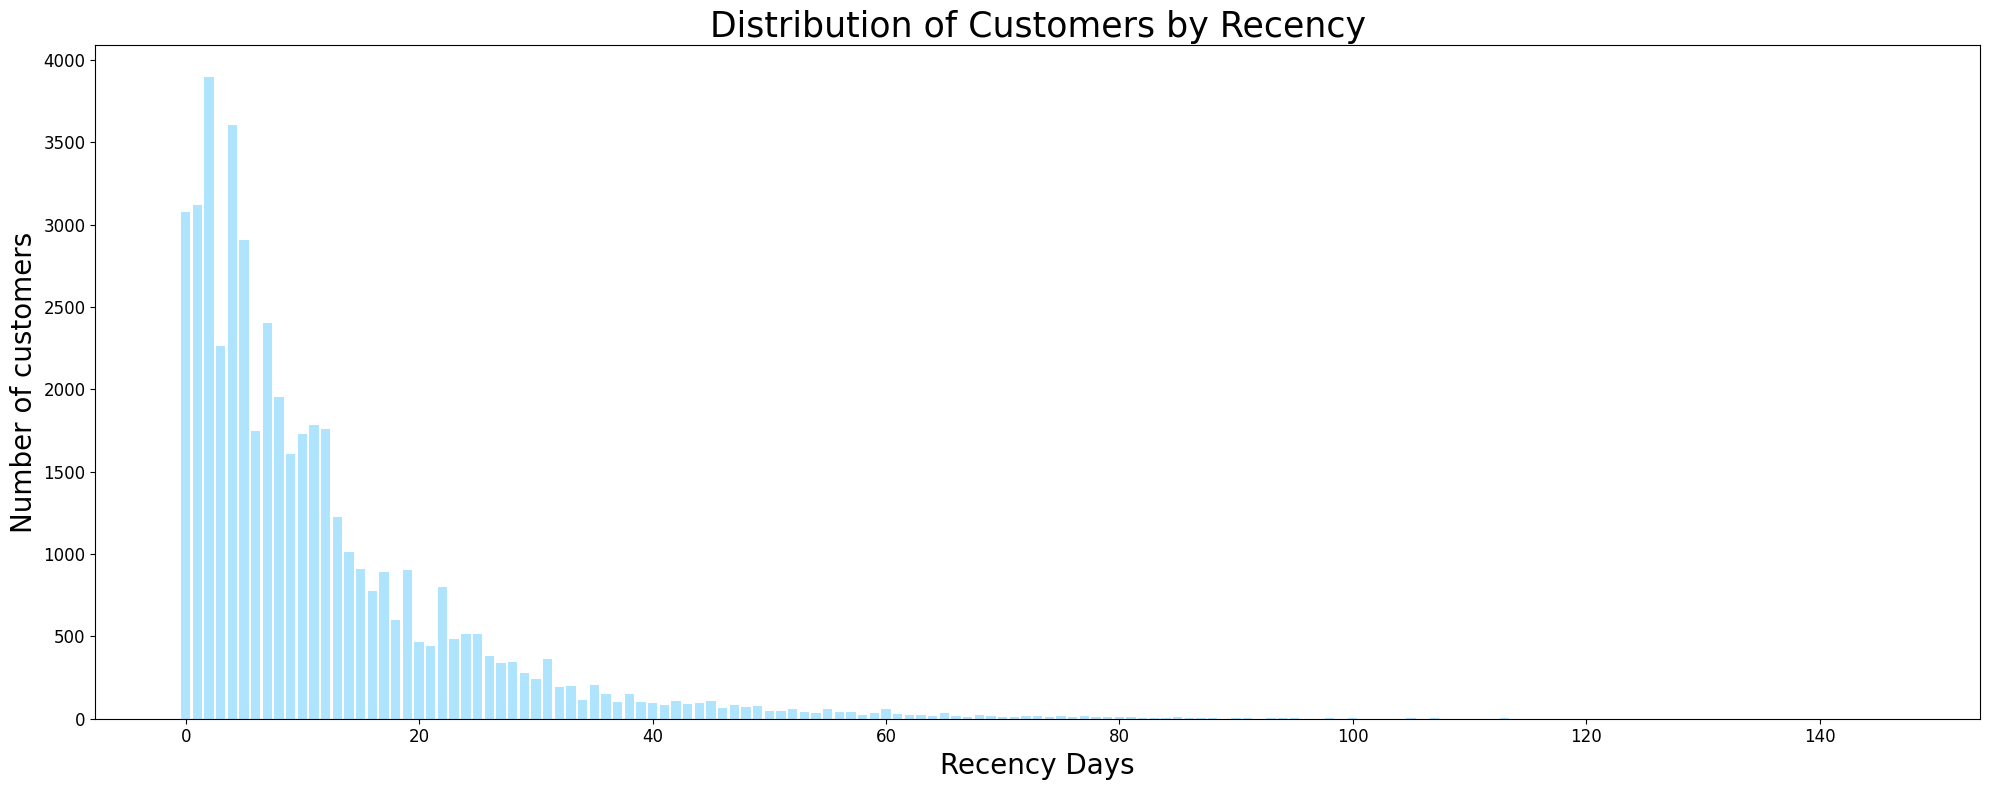

In [13]:
customer_by_recency.sort_values(by='RECENCY_DAYS', ascending=True, inplace=True) # Sort values in ascending order of customer
recency_index = customer_by_recency['RECENCY_DAYS'].tolist()
customer_values = customer_by_recency['NO_OF_CUST'].tolist()

# Create a figure and subplot
fig, V4 = plt.subplots(figsize=(20,8))

# Create a bar chart 
V4.bar(recency_index,customer_values, align = 'center', color='#AFE4FE') # align define the alignment of x-ticks

# Display data labels
#for x,y in zip(recency_index,customer_values):

#    label = x

#    plt.annotate(label, 
#                 (x,y), 
#                 textcoords="offset points", 
#                 xytext=(30,-3), 
#                 fontsize = 10,
#                 ha='center') 

# State title of plot and the axes labels
V4.set_title('Distribution of Customers by Recency', fontsize = 25)
V4.set_ylabel('Number of customers', fontsize = 20)
V4.set_xlabel('Recency Days', fontsize = 20)

# Set font size of ticks on the x-axis and y-axis
V4.tick_params(labelsize = 12, axis ='both')

# Set tight layout for figure
fig.tight_layout()

# Display plot
plt.show()

In [14]:
# Find recency days based on percentage of customer (30%)

# Sort the DataFrame by RECENCY_DAYS in ascending order
customer_by_recency = customer_by_recency.sort_values('RECENCY_DAYS')

# Calculate the cumulative sum of customer counts
customer_by_recency['CUMULATIVE_COUNT'] = customer_by_recency['NO_OF_CUST'].cumsum()

# Find the RECENCY_DAYS where 80% of the customers are at
target_percentage = 0.7
target_recency_days = None

for index, row in customer_by_recency.iterrows():
    if row['CUMULATIVE_COUNT'] >= target_percentage * customer_by_recency['NO_OF_CUST'].sum():
        target_recency_days = row['RECENCY_DAYS']
        break

# Print the result
print("RECENCY_DAYS where 70% of the customers are at:", target_recency_days)

RECENCY_DAYS where 70% of the customers are at: 13


In [15]:
# Sum of customers where RECENCY_DAYS is below or equal to 13
sum_below_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] <= 13]['NO_OF_CUST'].sum()

# Sum of customers where RECENCY_DAYS is more than 13
sum_above_13 = customer_by_recency[customer_by_recency['RECENCY_DAYS'] > 13]['NO_OF_CUST'].sum()

# Print the results
print("Sum of customers where RECENCY_DAYS is below or equal to 13:", sum_below_13)
print("Sum of customers where RECENCY_DAYS is more than 13:", sum_above_13)

Sum of customers where RECENCY_DAYS is below or equal to 13: 33053
Sum of customers where RECENCY_DAYS is more than 13: 13247


In food service industry, customer churn rates can range from 20% to 30% annually. For 70% of the customers, their recency days are at 13. Therefore, we round the recenecy days up to 14 days, which is 2 weeks to be considered churned.

For this model, we would be predicting the days to next purchase for each customer. After predicting the days to next purchase, if it is more than 14 days, the customer is considered churned, else not churned.

## 4. Data Preparation <a id="part4"></a>

In [16]:
# Getting last order date
lastest_transaction = order_header_df.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
order_header_df = order_header_df.withColumn("LAST_DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction, lastest_transaction))

In [17]:
# Getting date for two weeks before last transaction date provided
order_header_df = order_header_df.withColumn("two_weeks_before", F.date_sub("LAST_DATE", 14))

In [18]:
# Display order_header_df
order_header_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### 4.1 Getting first dataframe <a id="part4.1"></a>

In [19]:
# Get data till 2 weeks before last transaction date provided (first dataframe)
order_df1 = order_header_df.filter(F.col("ORDER_TS")<=F.col("TWO_WEEKS_BEFORE"))
order_df1.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [20]:
# Ensure timeframe is correct
order_df1.agg(F.min('ORDER_TS')).show()
order_df1.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2019-01-01 17:19:08  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-10-18 22:56:45  |
-----------------------



In [21]:
# Getting the latest purchase date for each customer in df1
customer_last_order_timestamp_df1 = order_df1.groupBy("CUSTOMER_ID").agg(F.max("ORDER_TS").alias("LAST_ORDER_TS"))
customer_last_order_timestamp_df1.show()

---------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |
---------------------------------------
|172289         |2022-10-12 20:00:46  |
|78907          |2022-10-18 09:09:03  |
|160383         |2022-10-18 19:24:40  |
|61295          |2022-09-12 16:39:09  |
|103028         |2022-10-18 21:22:57  |
|65147          |2022-10-12 11:39:42  |
|118051         |2022-10-10 09:30:54  |
|168904         |2022-10-08 11:16:51  |
|145789         |2022-10-17 18:45:50  |
|150780         |2022-10-18 13:14:21  |
---------------------------------------



In [22]:
# Getting last order date
lastest_transaction_df1 = order_df1.agg(F.max("ORDER_TS").alias("LAST_ORDER_TS")).collect()[0][0]
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("LAST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |
-------------------------------------------------------------
|114606         |2022-09-29 20:30:58  |2022-10-18 22:56:45  |
|134715         |2022-09-21 09:48:35  |2022-10-18 22:56:45  |
|83979          |2022-10-18 20:30:54  |2022-10-18 22:56:45  |
|29066          |2022-10-13 09:00:32  |2022-10-18 22:56:45  |
|31252          |2022-09-22 20:29:44  |2022-10-18 22:56:45  |
|68481          |2022-10-15 19:11:05  |2022-10-18 22:56:45  |
|20166          |2022-09-15 09:10:26  |2022-10-18 22:56:45  |
|6655           |2022-09-26 12:30:05  |2022-10-18 22:56:45  |
|86934          |2022-10-13 12:44:37  |2022-10-18 22:56:45  |
|142411         |2022-10-14 17:18:37  |2022-10-18 22:56:45  |
-------------------------------------------------------------



In [23]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.withColumn("days_df1", F.datediff("day", customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_last_order_timestamp_df1.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------
|83496          |2022-10-11 16:10:41  |2022-10-18 22:56:45  |7           |
|179636         |2022-10-01 19:27:11  |2022-10-18 22:56:45  |17          |
|39930          |2022-09-25 14:20:49  |2022-10-18 22:56:45  |23          |
|164938         |2022-09-27 14:10:19  |2022-10-18 22:56:45  |21          |
|176202         |2022-10-07 09:38:49  |2022-10-18 22:56:45  |11          |
|114424         |2022-10-09 19:17:28  |2022-10-18 22:56:45  |9           |
|71849          |2022-10-16 10:58:46  |2022-10-18 22:56:45  |2           |
|163551         |2022-10-14 11:19:12  |2022-10-18 22:56:45  |4           |
|150930         |2022-10-18 17:31:06  |2022-10-18 22:56:45  |0           |
|176242         |2022-10-10 17:42:43  |2022-10-18 22:56:45  |8           |
-------------------------

DO THE PAST 3 TRANS HERE

### 4.2 Recency <a id="part4.2"></a>

To calculate the recency of orders for each customer, we will take the last order timestamp of the customer minus the current date identified. 

In [24]:
# Creating a new dataframe and adding column with current date as the latest 
# transaction timestamp identified previously 

# Calculate recency days
customer_recency = customer_last_order_timestamp_df1.with_column("RECENCY_DAYS", F.datediff('day', customer_last_order_timestamp_df1["LAST_ORDER_TS"], customer_last_order_timestamp_df1["LAST_TRANS"]))
customer_recency.show()

-------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |"RECENCY_DAYS"  |
-------------------------------------------------------------------------------------------
|198931         |2022-08-16 12:58:37  |2022-10-18 22:56:45  |63          |63              |
|100814         |2022-10-08 18:32:53  |2022-10-18 22:56:45  |10          |10              |
|11771          |2022-09-29 20:07:33  |2022-10-18 22:56:45  |19          |19              |
|152747         |2022-10-04 19:30:24  |2022-10-18 22:56:45  |14          |14              |
|143894         |2022-09-18 13:48:24  |2022-10-18 22:56:45  |30          |30              |
|145678         |2022-09-13 21:42:47  |2022-10-18 22:56:45  |35          |35              |
|22505          |2022-10-18 18:19:58  |2022-10-18 22:56:45  |0           |0               |
|115216         |2022-10-15 09:36:23  |2022-10-18 22:56:45  |3           |3     

In [25]:
# Calculating the number of days since a customer bought from Tasty Bytes based 
# on the date difference between the current date and last order timestamp and 
# adding it into the customer_recency data frame

temp_customer_recency = customer_recency.select('CUSTOMER_ID','RECENCY_DAYS')

# Joining customer_recency and customer_df to make a new data frame which will be used for clustering
customer_last_order_timestamp_df1 = temp_customer_recency.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_recency.CUSTOMER_ID, lsuffix="", rsuffix="_RECENCY")

In [26]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
-------------------------------------------------------------------------------------------------------------------
|106777         |3               |106777                 |2022-10-15 10:57:04  |2022-10-18 22:56:45  |3           |
|16267          |1               |16267                  |2022-10-17 18:37:44  |2022-10-18 22:56:45  |1           |
|146214         |5               |146214                 |2022-10-13 08:42:19  |2022-10-18 22:56:45  |5           |
|97144          |3               |97144                  |2022-10-15 11:29:25  |2022-10-18 22:56:45  |3           |
|164825         |5               |164825                 |2022-10-13 18:27:48  |2022-10-18 22:56:45  |5           |
|127513         |2               |127513                 |2022-10-16 14:

### 4.3 Frequency <a id="part4.3"></a>

To calculate the frequency of orders for each customer, we will be calculating the total order by customers divided by the duration between their first order and the current date identified.

In [27]:
# Obtain the time stamp for each customer’s first order
customer_first_order_timestamp = order_df1.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp.show(n=5)

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|111150         |2019-01-04 21:08:39  |
|108935         |2019-01-06 13:38:47  |
|173074         |2019-01-06 18:53:39  |
|137846         |2019-01-10 18:58:28  |
|28098          |2019-01-23 13:08:41  |
---------------------------------------



In [28]:
# Calculating the total number of orders for each customer
total_order_by_cust = order_df1.group_by("CUSTOMER_ID").agg(F.count("ORDER_ID").alias("TOTAL_ORDER"))
total_order_by_cust.show(n=5)

---------------------------------
|"CUSTOMER_ID"  |"TOTAL_ORDER"  |
---------------------------------
|61615          |58             |
|199518         |57             |
|163672         |48             |
|73700          |54             |
|15972          |52             |
---------------------------------



In [29]:
# Joining the total number of orders, first order timestamp tables with the customer data
customer_freq = customer_df.join(customer_first_order_timestamp, customer_df.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")
customer_freq = customer_freq.join(total_order_by_cust, customer_freq.CUSTOMER_ID==total_order_by_cust.CUSTOMER_ID, lsuffix="", rsuffix="_NUM_ORDER")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “CUSTOMER_FREQUENCY” to calculate the frequency
customer_freq = customer_freq.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_freq = customer_freq.with_column("YEARS_WITH_US",F.datediff("day", customer_freq["FIRST_ORDER_TS"], customer_freq["CURRENT DATE"])/365)
customer_freq = customer_freq.with_column("CUSTOMER_FREQUENCY", customer_freq["TOTAL_ORDER"]/customer_freq["YEARS_WITH_US"])

customer_freq.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_NAME"  |"LAST_NAME"  |"CITY"     |"COUNTRY"      |"POSTAL_CODE"  |"PREFERRED_LANGUAGE"  |"GENDER"     |"FAVOURITE_BRAND"  |"MARITAL_STATUS"    |"CHILDREN_COUNT"  |"SIGN_UP_DATE"  |"BIRTHDAY_DATE"  |"E_MAIL"                     |"PHONE_NUMBER"  |"CUSTOMER_ID_FIRST_TS"  |"FIRST_ORDER_TS"     |"CUSTOMER_ID_NUM_ORDER"  |"TOTAL_ORDER"  |"CURRENT DATE"       |"YEARS_WITH_US"  |"CUSTOMER_FREQUENCY"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------

In [30]:
# Joining this table to the customer dataset that will be used for clustering later on
temp_customer_freq = customer_freq.select(["CUSTOMER_ID","CUSTOMER_FREQUENCY",'TOTAL_ORDER'])
customer_last_order_timestamp_df1 = temp_customer_freq.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_freq.CUSTOMER_ID, lsuffix="", rsuffix="_FREQUENCY")

In [31]:
# Display customer_last_order_timestamp
customer_last_order_timestamp_df1.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|169614         |23.934428             |72             |169614                   |6               |169614                 |2022-10-12 19:02:13  |2022-10-18 22:56:45  |6           |
|107415         |21.236361             |64             |107415                   |1               |107415                 |2022-10-17 15:09:43  |2022-10-18 22:56:45  |1           |
|105551         |18.879310             |54             |105551                   |13           

### 4.4 Monetary Value <a id="part4.4"></a>

To calculate the monetary value for each customer, we will be calculating the total sales generated by each customer divided by the number of years the customer has ordered with Tasty Bytes. 

In [32]:
 # Calculate the total sales generated by each customer 
total_amount_spent = order_df1.group_by("CUSTOMER_ID").agg(F.sum("ORDER_TOTAL").alias("TOTAL_SPENT"))

# Joining the total sales generated by each customer with the first order timestamp tables 
customer_monetary = total_amount_spent.join(customer_first_order_timestamp, total_amount_spent.CUSTOMER_ID==customer_first_order_timestamp.CUSTOMER_ID, lsuffix="", rsuffix="_FIRST_TS")

# Adding in relevant columns to the newly joined data frame such as “CURRENT DATE”, “YEARS_WITH_US”, and “MONETARY_VALUE” to calculate the monetary value
customer_monetary = customer_monetary.with_column("CURRENT DATE", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), lastest_transaction_df1, lastest_transaction_df1))
customer_monetary = customer_monetary.with_column("YEARS_WITH_US",F.datediff("day", customer_monetary["FIRST_ORDER_TS"], customer_monetary["CURRENT DATE"])/365)
customer_monetary = customer_monetary.with_column("MONETARY_VALUE", F.col("TOTAL_SPENT")/F.col("YEARS_WITH_US"))

In [33]:
# Joining this table to the customer dataset that will be used for clustering later on 
temp_customer_mon = customer_monetary.select(['CUSTOMER_ID','TOTAL_SPENT','YEARS_WITH_US','MONETARY_VALUE'])
customer_last_order_timestamp_df1 = temp_customer_mon.join(customer_last_order_timestamp_df1, customer_last_order_timestamp_df1.CUSTOMER_ID==temp_customer_mon.CUSTOMER_ID, lsuffix="", rsuffix="_MONETARY")

In [34]:
# Display customer_last_order_timestamp_df1
customer_last_order_timestamp_df1.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_ID_MONETARY"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"CUSTOMER_ID_FREQUENCY"  |"RECENCY_DAYS"  |"CUSTOMER_ID_RECENCY"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|183793         |2161.5000      |3.213699         |672.5894366585    |183793                  |17.425403             |56             |183793                   |3               |183793                 |2022-10-15 09:38:31  |

In [35]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MONETARY", "CUSTOMER_ID_FREQUENCY", "CUSTOMER_ID_RECENCY"])
customer_last_order_timestamp_df1.show(10)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|63821          |2575.7500      |3.490411         |737.9503445296    |18.049450             |63             |25              |2022-09-23 13:43:38  |2022-10-18 22:56:45  |25          |
|55439          |2629.7500      |3.490411         |753.4213019613    |16.903453             |59             |10              |2022-10-08 12:18:19  |2022-10-18 22:56:45  |10          |
|199926         |2805.5000      |3.139726         |893.5493097168    |21.020943 

CLUSTERING

### 4.5 Calculation of Average Days between Purchases <a id="part4.5"></a>

In [36]:
# Finding the average days between purchase for each customer
customer_order_times = order_df1.sort(col("CUSTOMER_ID"), col("ORDER_TS"))
customer_order_times = customer_order_times.withColumn("prev_order_date", F.lag(col("ORDER_TS"), 1).over(Window.partitionBy("CUSTOMER_ID").orderBy("ORDER_TS"))).withColumn("days_between", F.datediff('day', col("prev_order_date"), col("ORDER_TS")))
customer_average_days = customer_order_times.groupBy("CUSTOMER_ID").avg("days_between")
customer_average_days = customer_average_days.sort(col('CUSTOMER_ID'))
customer_average_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |
---------------------------------------
|22             |29.785714            |
|42             |33.864865            |
|59             |33.486486            |
|65             |29.095238            |
|106            |23.765957            |
|118            |29.540541            |
|166            |19.214286            |
|176            |28.718750            |
|189            |26.829787            |
|204            |28.823529            |
---------------------------------------



In [37]:
# Adding the average days between purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_average_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_average_days.CUSTOMER_ID, lsuffix="", rsuffix="_AVG_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|57890          |16.771930            |57890                                    |2166.2500      |2.704110         |801.0953696410    |21.448832             |58             |31              |2022-09-17 20:18:31  |2022-10-18 22:56:45  |31          |
|101776 

### 4.6 Calculation the Minimum Number of Days without Customer Purchase <a id="part4.6"></a>

In [38]:
# Finding the minimum days without purchase for each customer
customer_min_days = customer_order_times.groupBy("CUSTOMER_ID").min("days_between")
customer_min_days = customer_min_days.sort(col('CUSTOMER_ID'))
customer_min_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |
---------------------------------------
|22             |1                    |
|42             |1                    |
|59             |1                    |
|65             |2                    |
|106            |1                    |
|118            |1                    |
|166            |1                    |
|176            |1                    |
|189            |1                    |
|204            |3                    |
---------------------------------------



In [39]:
# Adding the minimum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_min_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_min_days.CUSTOMER_ID, lsuffix="", rsuffix="_MIN_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|172108         |2                    |172108                   

### 4.7 Calculation the Maximum Number of Days without Customer Purchase <a id="part4.7"></a>

In [40]:
# Finding the maximum days without purchase for each customer
customer_max_days = customer_order_times.groupBy("CUSTOMER_ID").max("days_between")
customer_max_days = customer_max_days.sort(col('CUSTOMER_ID'))
customer_max_days.show()

---------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |
---------------------------------------
|22             |173                  |
|42             |167                  |
|59             |390                  |
|65             |207                  |
|106            |158                  |
|118            |158                  |
|166            |119                  |
|176            |139                  |
|189            |164                  |
|204            |172                  |
---------------------------------------



In [41]:
# Adding the maximum number of days without purchase into customer_last_order_timestamp_df1
customer_last_order_timestamp_df1 = customer_max_days.join(customer_last_order_timestamp_df1, 
                                customer_last_order_timestamp_df1.CUSTOMER_ID==customer_max_days.CUSTOMER_ID, lsuffix="", rsuffix="_MAX_DAYS_WITHOUT_PURCHASE")
customer_last_order_timestamp_df1.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE"  |"MIN(DAYS_BETWEEN)"  |"CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE"  |"AVG(DAYS_BETWEEN)"  |"CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
# Dropping of irrelevant and unnecessary columns that have been introduced during joining of dataframes in previous steps
customer_last_order_timestamp_df1 = customer_last_order_timestamp_df1.drop(["CUSTOMER_ID_MAX_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_MIN_DAYS_WITHOUT_PURCHASE", "CUSTOMER_ID_AVG_DAYS_WITHOUT_PURCHASE"])
customer_last_order_timestamp_df1.show(10)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"LAST_ORDER_TS"      |"LAST_TRANS"         |"DAYS_DF1"  |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|101291         |65                   |1                    |16.360656            |2715.2500      |2.745205         |989.0882465972    |22.584834             |62             |4               |2022-10-14 20:23:35  |2022-10-18 22:56:45  |4           |


### 4.8 Getting second dataframe <a id="part4.8"></a>

In [43]:
# Get last 2 weeks before last transaction date provided (second dataframe)
order_df2 = order_header_df.filter(F.col("ORDER_TS")>F.col("TWO_WEEKS_BEFORE"))
order_df2.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"ORDER_ID"  |"TRUCK_ID"  |"LOCATION_ID"  |"CUSTOMER_ID"  |"DISCOUNT_ID"  |"SHIFT_ID"  |"SHIFT_START_TIME"  |"SHIFT_END_TIME"  |"ORDER_CHANNEL"  |"ORDER_TS"           |"SERVED_TS"  |"ORDER_CURRENCY"  |"ORDER_AMOUNT"  |"ORDER_TAX_AMOUNT"  |"ORDER_DISCOUNT_AMOUNT"  |"ORDER_TOTAL"  |"CUSTOMER_ID_US"  |"LAST_DATE"          |"TWO_WEEKS_BEFORE"   |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
# Ensure timeframe is correct
order_df2.agg(F.min('ORDER_TS')).show()
order_df2.agg(F.max('ORDER_TS')).show()

-----------------------
|"MIN(ORDER_TS)"      |
-----------------------
|2022-10-19 08:00:15  |
-----------------------

-----------------------
|"MAX(ORDER_TS)"      |
-----------------------
|2022-11-01 22:58:56  |
-----------------------



In [45]:
# Getting the earliest purchase date for each customer in df2
customer_first_order_timestamp_df2 = order_df2.groupBy("CUSTOMER_ID").agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.sort(col("FIRST_ORDER_TS"))
customer_first_order_timestamp_df2.show()

---------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |
---------------------------------------
|184287         |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |
|196281         |2022-10-19 08:00:59  |
|127806         |2022-10-19 08:01:29  |
|170016         |2022-10-19 08:01:47  |
|64450          |2022-10-19 08:01:53  |
|191049         |2022-10-19 08:01:59  |
|118969         |2022-10-19 08:02:19  |
|192268         |2022-10-19 08:04:20  |
|95980          |2022-10-19 08:04:33  |
---------------------------------------



In [46]:
# Getting first order date
earliest_transaction_df2 = order_df2.agg(F.min("ORDER_TS").alias("FIRST_ORDER_TS")).collect()[0][0]
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("FIRST_TRANS", F.iff(F.col("CUSTOMER_ID") == F.col("CUSTOMER_ID"), earliest_transaction_df2, earliest_transaction_df2))
customer_first_order_timestamp_df2.show()

-------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |
-------------------------------------------------------------
|184287         |2022-10-19 08:00:15  |2022-10-19 08:00:15  |
|42060          |2022-10-19 08:00:46  |2022-10-19 08:00:15  |
|196281         |2022-10-19 08:00:59  |2022-10-19 08:00:15  |
|127806         |2022-10-19 08:01:29  |2022-10-19 08:00:15  |
|170016         |2022-10-19 08:01:47  |2022-10-19 08:00:15  |
|64450          |2022-10-19 08:01:53  |2022-10-19 08:00:15  |
|191049         |2022-10-19 08:01:59  |2022-10-19 08:00:15  |
|118969         |2022-10-19 08:02:19  |2022-10-19 08:00:15  |
|192268         |2022-10-19 08:04:20  |2022-10-19 08:00:15  |
|95980          |2022-10-19 08:04:33  |2022-10-19 08:00:15  |
-------------------------------------------------------------



In [47]:
# Getting the date diff from customer last order to the date 2 weeks before the latest provided transaction date in df1
customer_first_order_timestamp_df2 = customer_first_order_timestamp_df2.withColumn("days_df2", F.datediff("day", customer_first_order_timestamp_df2["FIRST_TRANS"], customer_first_order_timestamp_df2["FIRST_ORDER_TS"]))
customer_first_order_timestamp_df2.show()

--------------------------------------------------------------------------
|"CUSTOMER_ID"  |"FIRST_ORDER_TS"     |"FIRST_TRANS"        |"DAYS_DF2"  |
--------------------------------------------------------------------------
|92790          |2022-10-21 21:53:32  |2022-10-19 08:00:15  |2           |
|50425          |2022-10-21 21:53:45  |2022-10-19 08:00:15  |2           |
|124094         |2022-10-21 21:53:53  |2022-10-19 08:00:15  |2           |
|194703         |2022-10-21 21:54:45  |2022-10-19 08:00:15  |2           |
|67009          |2022-10-21 21:54:53  |2022-10-19 08:00:15  |2           |
|157402         |2022-10-21 21:55:41  |2022-10-19 08:00:15  |2           |
|91608          |2022-10-21 21:56:22  |2022-10-19 08:00:15  |2           |
|80169          |2022-10-21 21:56:28  |2022-10-19 08:00:15  |2           |
|180901         |2022-10-21 21:56:37  |2022-10-19 08:00:15  |2           |
|163630         |2022-10-21 21:56:48  |2022-10-19 08:00:15  |2           |
-------------------------

### 4.9 Merging dataframes <a id="part4.9"></a>

In [48]:
final_df = customer_last_order_timestamp_df1.join(customer_first_order_timestamp_df2, customer_last_order_timestamp_df1.CUSTOMER_ID == customer_first_order_timestamp_df2.CUSTOMER_ID, lsuffix = "", rsuffix = "_ID")
final_df = final_df.drop("CUSTOMER_ID_ID", "FIRST_ORDER_TS", "FIRST_TRANS", "LAST_ORDER_TS", "LAST_TRANS")
final_df.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"DAYS_DF1"  |"DAYS_DF2"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|99391          |63                   |1                    |15.523077            |2777.5000      |2.794521         |993.9091529461    |23.617643             |66             |11              |11          |11          |
|144918         |55                   |1                    |16.275862            |2332.7500      |2.591781         |900.056

#### 4.9.1 Adding Target Variable <a id="part4.9.1"></a>

In [49]:
final_df = final_df.withColumn("TARGET", col("DAYS_DF1")+col("DAYS_DF2"))
final_df = final_df.drop("DAYS_DF1", "DAYS_DF2")
final_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CUSTOMER_ID"  |"MAX(DAYS_BETWEEN)"  |"MIN(DAYS_BETWEEN)"  |"AVG(DAYS_BETWEEN)"  |"TOTAL_SPENT"  |"YEARS_WITH_US"  |"MONETARY_VALUE"  |"CUSTOMER_FREQUENCY"  |"TOTAL_ORDER"  |"RECENCY_DAYS"  |"TARGET"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|29799          |58                   |1                    |14.296875            |2647.7500      |2.561644         |1033.6135700355   |25.374330             |65             |20              |23        |
|86589          |100                  |1                    |16.610169            |2194.5000      |2.690411         |815.6746311251    |22.301425             |60             |2        

## 5. Model Building <a id="part5"></a>

### 5.1 Scaling <a id="part5.1"></a>

In [50]:
# Convert to pandas
final_df = final_df.to_pandas()

# save dataframe of customer_id 
customer_id_df = final_df["CUSTOMER_ID"]

final_df = final_df.drop(["CUSTOMER_ID"],  axis = 1)

final_df.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,TARGET
0,99,1,17.543860,1797.25,2.772603,648.2175774895,20.918970,58,12,18
1,132,1,19.979167,2051.50,2.786301,736.2808253667,17.586040,49,58,62
2,139,1,22.069767,1659.50,2.627397,631.6137226312,16.746613,44,10,19
3,73,1,16.403509,2047.25,2.578082,794.0980930785,22.497345,58,6,8
4,104,1,19.820000,1959.50,2.764384,708.8378459722,18.448956,51,18,24


In [51]:
# Drop target
target = final_df['TARGET']
final_df.drop('TARGET', axis = 1, inplace = True)

scaler = StandardScaler()
scaler.fit(final_df)

final_scaled = scaler.transform(final_df)
final_scaled = pd.DataFrame(final_scaled, columns=final_df.columns)

#assign target variable back to scaled data frame
final_scaled = final_scaled.assign(TARGET = target)

final_scaled.head()

,MAX(DAYS_BETWEEN),MIN(DAYS_BETWEEN),AVG(DAYS_BETWEEN),TOTAL_SPENT,YEARS_WITH_US,MONETARY_VALUE,CUSTOMER_FREQUENCY,TOTAL_ORDER,RECENCY_DAYS,TARGET
0,-0.389774,-0.247799,-0.608732,-0.582613,-0.591722,-0.344569,0.628990,0.408196,0.005387,18
1,0.108492,-0.247799,-0.217580,-0.053261,-0.550093,0.151675,-0.194914,-0.460954,3.564675,62
2,0.214184,-0.247799,0.118205,-0.869411,-1.033010,-0.438133,-0.402421,-0.943815,-0.149365,19
3,-0.782348,-0.247799,-0.791891,-0.062110,-1.182881,0.477480,1.019166,0.408196,-0.458868,8
4,-0.314280,-0.247799,-0.243145,-0.244807,-0.616700,-0.002968,0.018400,-0.267809,0.469642,24


### 5.2 Train Test Split <a id="part5.2"></a>

In [52]:
# Define ratio for model 
train_ratio = 0.70
test_ratio = 0.20
holdout_ratio = 0.10

# Define Model Inputs (X) and Output (y)
X = final_scaled.drop('TARGET',axis=1)
y = final_scaled["TARGET"]

# Split both Inputs (X) and Ouput (y) into training set (70%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-train_ratio, random_state=1)
X_holdout, X_test, y_holdout, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + holdout_ratio)) 

### 5.3 Linear Regression <a id="part5.3"></a>

In [53]:
# Create the model "lg"
lg = LinearRegression()
lg.fit(X_train, y_train)

#MSE

train_mse = mean_squared_error(lg.predict(X_train), y_train)
print('The Training Mean Squared Error for Linear Regression Model is: ', train_mse)
test_mse = mean_squared_error(lg.predict(X_test), y_test)
print('The Testing Mean Squared Error for Linear Regression Model is: ',test_mse)

print('')

#R^2

train_R2 = lg.score(X_train, y_train)
print('The Training R^2 for Linear Regression Model is: ', train_R2)

test_R2 = lg.score(X_test, y_test)
print('The Testing R^2 for Linear Regression Model is: ', test_R2)

The Training Mean Squared Error for Linear Regression Model is:  14.221078482809014
The Testing Mean Squared Error for Linear Regression Model is:  14.144732057101722

The Training R^2 for Linear Regression Model is:  0.922393742192671
The Testing R^2 for Linear Regression Model is:  0.9188806669313972


In [54]:
##### holdout model

# Create the model "lg"
lg = LinearRegression()
lg.fit(X_holdout, y_holdout)


#MSE

holdout_mse = mean_squared_error(lg.predict(X_holdout), y_holdout)
print('The Holdout Mean Squared Error for Linear Regression Model is: ', holdout_mse)

print('')

#R^2

holdout_R2 = lg.score(X_holdout, y_holdout)
print('The Holdout R^2 for Linear Regression Model is: ', holdout_R2)

The Holdout Mean Squared Error for Linear Regression Model is:  14.249855309918349

The Holdout R^2 for Linear Regression Model is:  0.9219751203396672
